# Урок 4. Uplift-моделирование

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score

from catboost import CatBoostClassifier
from sklift.models import ClassTransformation
from sklift.models import TwoModels

Домашнее задание
1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [2]:
df = pd.read_csv('data.csv')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [3]:
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)

In [4]:
df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [5]:
df['treatment'] = df["treatment"].replace({"No Offer": 0, "Discount": 1, "Buy One Get One": 1})
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

In [6]:
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,1,0
63996,5,38.91,0,1,Urban,1,Phone,1,0
63997,6,29.99,1,0,Urban,1,Phone,1,0
63998,1,552.94,1,0,Surburban,1,Multichannel,1,0


3. сделать разбиение набора данных не тренировочную и тестовую выборки

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target']),
                                                    df['target'],
                                                    test_size=0.3,
                                                    random_state=10,
                                                   )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((44800, 8), (19200, 8), (44800,), (19200,))

4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

In [8]:
# Проверяем типы данных
df.dtypes

recency            int64
history          float64
used_discount      int64
used_bogo          int64
zip_code          object
is_referral        int64
channel           object
treatment          int64
target             int64
dtype: object

In [9]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,treatment,target
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.667094,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.471257,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
df['channel'].value_counts()

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

In [11]:
df['zip_code'].value_counts()

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

In [12]:
#Переводим все категориальные признаки (zip_code и channel) в числовые 
ch = df['channel'].value_counts().index
for n, el in enumerate(ch):
    print(el, n)
    df.loc[df['channel'] == el, 'channel'] = n
ch = df['zip_code'].value_counts().index
for n, el in enumerate(ch):
    print(el, n)
    df.loc[df['zip_code'] == el, 'zip_code'] = n
df

Web 0
Phone 1
Multichannel 2
Surburban 0
Urban 1
Rural 2


,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,0,0,1,1,0
1,6,329.08,1,1,2,1,0,0,0
2,7,180.65,0,1,0,1,0,1,0
3,9,675.83,1,0,2,1,0,1,0
4,2,45.34,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,1,0,0,1,0
63996,5,38.91,0,1,1,1,1,1,0
63997,6,29.99,1,0,1,1,1,1,0
63998,1,552.94,1,0,0,1,2,1,0


In [13]:
#Посмотрим на распределение классов в выборках
y_train.value_counts(normalize=True)

0    0.853973
1    0.146027
Name: target, dtype: float64

In [14]:
y_test.value_counts(normalize=True)

0    0.851458
1    0.148542
Name: target, dtype: float64

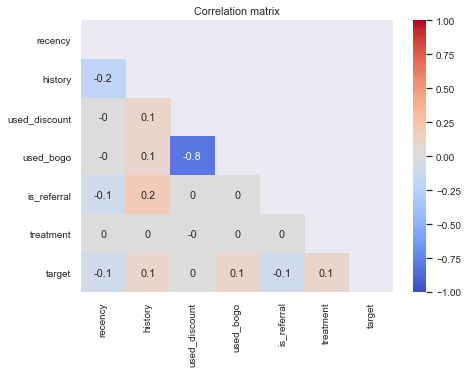

In [15]:
plt.figure(figsize=(7, 5))
sns.set(font_scale=0.9)
sns.heatmap(round(df.corr(), 1), annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=np.triu(df.corr()))
plt.title('Correlation matrix')

plt.show()

между used_discount и used_bogo обратная корреляция

5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

In [16]:
treat_train = X_train['treatment']
treat_test=  X_test['treatment']
treat_train_full = df['treatment']

In [17]:
cat_features = ['zip_code', 'channel']

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

In [18]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

In [19]:

ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)



In [20]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [21]:
pd.DataFrame(data=models_results)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.114023,0.092142
1,ClassTransformation,0.265158,0.221723
2,TwoModels,0.098324,0.092068


7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [22]:
X_train_tree = pd.concat([X_train.drop('zip_code', 1), 
                          pd.get_dummies(X_train['zip_code'], prefix='zip_code')], 1)

X_train_tree = pd.concat([X_train.drop('channel', 1), 
                          pd.get_dummies(X_train['channel'], prefix='channel')], 1)

features = [col for col in X_train_tree]

In [23]:
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

%%time

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

ModuleNotFoundError: No module named 'causalml.inference'

8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion

9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево